<a href="https://colab.research.google.com/github/f-has/mimic4obesityreproduction/blob/main/Exploratory_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Reproduction of Severity of Illness Scores May Misclassify Critically Ill Obese Patients: Main Statistical Analysis

## Setup

We need to:

1. Import libraries.
2. Authenticate with Google.
3. Set the `project-id` which will be used for billing query costs. Query costs for this tutorial are typically ~0.01 - 0.05 USD.

In [1]:
!pip install -U -q pandas-profiling==3.0.0 pandas pyyaml==5.4.1 MarkupSafe==2.0.1
!jupyter nbextension enable --py widgetsnbextension

     |████████████████████████████████| 248 kB 7.1 MB/s 
     |████████████████████████████████| 636 kB 6.3 MB/s 
     |████████████████████████████████| 102 kB 41.3 MB/s 
     |████████████████████████████████| 3.1 MB 42.6 MB/s 
     |████████████████████████████████| 62 kB 739 kB/s 
     |████████████████████████████████| 690 kB 53.4 MB/s 
     |████████████████████████████████| 355 kB 46.3 MB/s 
     |████████████████████████████████| 812 kB 46.5 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.1 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.
Enabling notebook extension jupyter-js-widgets/extension...
Paths used for configuration of notebook: 
    	/root/.jupyter/nbconfig/notebook.json
      - Validating: OK
Paths 

In [2]:
# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

# You only need to authenticate once per session.
auth.authenticate_user()

# Import libraries
from datetime import timedelta
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats

# below imports are used for pretty pandas dataframes and plots
from IPython.display import display, HTML
%matplotlib inline
plt.style.use('ggplot')


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.impute import SimpleImputer

from pandas_profiling import ProfileReport

# Set up environment variables
project_id = 'final-project-2022-354718'
os.environ["GOOGLE_CLOUD_PROJECT"] = project_id

# Read data from BigQuery into pandas dataframes.
def run_query(query, project_id=project_id):
    return pd.io.gbq.read_gbq(
        query,
        project_id=project_id,
        dialect="standard"
    )
if project_id == 'CHANGE-ME':
  raise ValueError('You must change project_id to your GCP project at the top of this cell.')

# test it works
df = run_query("""
SELECT *
FROM `final-project-2022-354718.Obs.final_cohort`
""")
assert df.shape[0] >= 1, 'unable to query MIMIC!'
display(df.head())


/usr/local/lib/python3.7/dist-packages/distributed/config.py:20: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


subject_id   hadm_id   stay_id           admittime  exclude_non_adult  \
0    17583589  28926250  34684932 2184-05-31 07:45:00                  0   
1    10242302  25476687  39647285 2155-01-08 03:44:00                  0   
2    18453450  24676167  38623255 2171-12-13 08:10:00                  0   
3    19024087  23464962  34448487 2121-11-26 00:00:00                  0   
4    15248565  26705577  38910085 2116-11-02 00:00:00                  0   

   exclude_readmission  exclude_lab_result  exclude_weight  exclude_height  \
0                    0                   0               0               0   
1                    0                   0               0               0   
2                    0                   0               0               0   
3                    0                   0               0               0   
4                    0                   0               0               0   

   exclude_bmi  bmi_group        bmi  
0            0          0  20.126385  
1            0          0  20.342798  
2            0          0  21.152344  
3            0          0  24.980469  
4            0          0  24.980469

Load datasets from google query.


In [3]:
#Pull tables from google cloud

print('\n'.join(['='*20, 'Final cohort normal', '='*20]))

coh_fin_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.final_cohort`
WHERE bmi_group=0
order by stay_id
''')
display(coh_fin_norm.head())

print('\n'.join(['='*20, 'Final cohort obese', '='*20]))

coh_fin_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.final_cohort`
WHERE bmi_group=1
order by stay_id
''')
display(coh_fin_obese.head())

print('\n'.join(['='*20, 'baseline demographics normal', '='*20]))

baseline_dem_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.baseline_demographics`
WHERE bmi_group=0
order by stay_id
''')
display(baseline_dem_norm.head())


print('\n'.join(['='*20, 'baseline demographics obese', '='*20]))

baseline_dem_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.baseline_demographics`
WHERE bmi_group=1
order by stay_id
''')
display(baseline_dem_obese.head())


print('\n'.join(['='*20, 'ICU lab results normal', '='*20]))

ICU_lab_results_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(ICU_lab_results_norm.head())


print('\n'.join(['='*20, 'ICU lab results obese', '='*20]))

ICU_lab_results_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(ICU_lab_results_obese.head())



print('\n'.join(['='*20, 'baseline lab results normal', '='*20]))

baseline_lab_results_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_baseline`
WHERE bmi_group=0
order by stay_id
''')
display(baseline_lab_results_norm.head())


print('\n'.join(['='*20, ' baseline lab results obese', '='*20]))

baseline_lab_results_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.lab_results_baseline`
WHERE bmi_group=1
order by stay_id
''')
display(baseline_lab_results_obese.head())



print('\n'.join(['='*20, 'Mechanical ventilation normal', '='*20]))

mechanical_vent_first_day_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.mechanical_vent_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(mechanical_vent_first_day_norm.head())


print('\n'.join(['='*20, ' Mechanical ventilation obese', '='*20]))

mechanical_vent_first_day_obese = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.mechanical_vent_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(mechanical_vent_first_day_obese.head())




print('\n'.join(['='*20, 'Renal replacement therapy normal', '='*20]))

rrt_first_day_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.rrt_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(rrt_first_day_norm.head())


print('\n'.join(['='*20, ' Renal replacement therapy obese', '='*20]))

rrt_first_day_obese= run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.rrt_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(rrt_first_day_obese.head())




print('\n'.join(['='*20, 'vasopressors normal', '='*20]))

vasopressors_first_day_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.vasopressors_first_day`
WHERE bmi_group=0
order by stay_id
''')
display(vasopressors_first_day_norm.head())


print('\n'.join(['='*20, ' vasopressors obese', '='*20]))

vasopressors_first_day_obese= run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.vasopressors_first_day`
WHERE bmi_group=1
order by stay_id
''')
display(vasopressors_first_day_obese.head())


print('\n'.join(['='*20, ' severity score normal', '='*20]))

severity_score_norm = run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.severity_score`
WHERE bmi_group=0
order by stay_id
''')
display(severity_score_norm.head())


print('\n'.join(['='*20, ' severity score obese', '='*20]))

severity_score_obese= run_query(f'''
SELECT *
FROM `final-project-2022-354718.Obs.severity_score`
WHERE bmi_group=1
order by stay_id
''')
display(severity_score_obese.head())













Final cohort normal


subject_id   hadm_id   stay_id           admittime  exclude_non_adult  \
0    14036785  25517749  30008105 2146-10-29 00:00:00                  0   
1    11317133  20143910  30016009 2129-09-21 07:15:00                  0   
2    16782996  29432324  30047249 2158-04-01 07:15:00                  0   
3    15956706  26653641  30117047 2121-05-25 13:17:00                  0   
4    15983568  27344395  30128855 2173-01-02 01:08:00                  0   

   exclude_readmission  exclude_lab_result  exclude_weight  exclude_height  \
0                    0                   0               0               0   
1                    0                   0               0               0   
2                    0                   0               0               0   
3                    0                   0               0               0   
4                    0                   0               0               0   

   exclude_bmi  bmi_group        bmi  
0            0          0  23.287037  
1            0          0  22.837370  
2            0          0  20.390625  
3            0          0  24.326531  
4            0          0  18.958150

Final cohort obese


subject_id   hadm_id   stay_id           admittime  exclude_non_adult  \
0    17907707  24556282  30068359 2111-06-14 00:00:00                  0   
1    13073338  23159892  30076188 2174-10-25 00:00:00                  0   
2    17924767  25031760  30091276 2170-08-05 07:30:00                  0   
3    16748556  27998771  30093379 2136-11-16 01:06:00                  0   
4    17650020  22362982  30108158 2140-12-26 11:45:00                  0   

   exclude_readmission  exclude_lab_result  exclude_weight  exclude_height  \
0                    0                   0               0               0   
1                    0                   0               0               0   
2                    0                   0               0               0   
3                    0                   0               0               0   
4                    0                   0               0               0   

   exclude_bmi  bmi_group        bmi  
0            0          1  34.178145  
1            0          1  31.958617  
2            0          1  30.636926  
3            0          1  38.992282  
4            0          1  34.220408

baseline demographics normal


subject_id   hadm_id   stay_id           admittime  exclude_non_adult  \
0    14036785  25517749  30008105 2146-10-29 00:00:00                  0   
1    11317133  20143910  30016009 2129-09-21 07:15:00                  0   
2    16782996  29432324  30047249 2158-04-01 07:15:00                  0   
3    16782996  29432324  30047249 2158-04-01 07:15:00                  0   
4    15956706  26653641  30117047 2121-05-25 13:17:00                  0   

   exclude_readmission  exclude_lab_result  exclude_weight  exclude_height  \
0                    0                   0               0               0   
1                    0                   0               0               0   
2                    0                   0               0               0   
3                    0                   0               0               0   
4                    0                   0               0               0   

   exclude_bmi  ...  ethnicity         admittime_1           dischtime  \
0            0  ...      WHITE 2146-10-29 00:00:00 2146-11-02 17:56:00   
1            0  ...    UNKNOWN 2129-09-21 07:15:00 2129-09-27 13:40:00   
2            0  ...      WHITE 2158-04-01 07:15:00 2158-04-09 15:00:00   
3            0  ...      WHITE 2158-04-01 07:15:00 2158-04-09 15:00:00   
4            0  ...      WHITE 2121-05-25 13:17:00 2121-06-01 17:30:00   

   hospital_expire_flag  marital_status_fin      insurance_fin  \
0                     0             Married  Medicare/Medicaid   
1                     0       other/unknown      Private/Other   
2                     0             Married      Private/Other   
3                     0             Married      Private/Other   
4                     0       other/unknown  Medicare/Medicaid   

   admission_type_fin source_of_admission_fin  \
0               Other      Physician referral   
1               Other      Physician referral   
2               Other      Physician referral   
3               Other      Physician referral   
4           Emergency      Physician referral   

                             icu_adm_type_fin charlson_comorbidity_index  
0               Cardiac surgery recovery unit                          4  
1               Cardiac surgery recovery unit                          8  
2  Surgical ICU/trauma ICU/coronary care unit                          1  
3  Surgical ICU/trauma ICU/coronary care unit                          1  
4               Cardiac surgery recovery unit                          7  

[5 rows x 27 columns]

baseline demographics obese


subject_id   hadm_id   stay_id           admittime  exclude_non_adult  \
0    17907707  24556282  30068359 2111-06-14 00:00:00                  0   
1    13073338  23159892  30076188 2174-10-25 00:00:00                  0   
2    17924767  25031760  30091276 2170-08-05 07:30:00                  0   
3    16748556  27998771  30093379 2136-11-16 01:06:00                  0   
4    17650020  22362982  30108158 2140-12-26 11:45:00                  0   

   exclude_readmission  exclude_lab_result  exclude_weight  exclude_height  \
0                    0                   0               0               0   
1                    0                   0               0               0   
2                    0                   0               0               0   
3                    0                   0               0               0   
4                    0                   0               0               0   

   exclude_bmi  ...  ethnicity         admittime_1           dischtime  \
0            0  ...      WHITE 2111-06-14 00:00:00 2111-06-23 19:03:00   
1            0  ...      WHITE 2174-10-25 00:00:00 2174-10-31 17:40:00   
2            0  ...      OTHER 2170-08-05 07:30:00 2170-08-08 13:45:00   
3            0  ...      WHITE 2136-11-16 01:06:00 2136-11-20 14:45:00   
4            0  ...      WHITE 2140-12-26 11:45:00 2141-01-01 18:00:00   

   hospital_expire_flag  marital_status_fin  insurance_fin  \
0                     0             Married  Private/Other   
1                     0             Married  Private/Other   
2                     0             Married  Private/Other   
3                     0             Married  Private/Other   
4                     0             Married  Private/Other   

   admission_type_fin source_of_admission_fin               icu_adm_type_fin  \
0               Other      Physician referral  Cardiac surgery recovery unit   
1               Other      Physician referral  Cardiac surgery recovery unit   
2            Elective      Physician referral  Cardiac surgery recovery unit   
3               Other      Physician referral  Cardiac surgery recovery unit   
4               Other      Physician referral  Cardiac surgery recovery unit   

  charlson_comorbidity_index  
0                          3  
1                          8  
2                          2  
3                          1  
4                          5  

[5 rows x 27 columns]

ICU lab results normal


stay_id  bmi_group  icu_wbc  icu_platelets  icu_NA  icu_k  icu_BUN  \
0  30008105          0     13.3          162.0   136.0    4.6      9.0   
1  30016009          0      9.3          143.0   143.0    4.3     26.0   
2  30047249          0      6.0          150.0   142.0    4.5     17.0   
3  30117047          0     13.6          143.0   136.0    4.9     17.0   
4  30128855          0     20.6          379.0   148.0    4.2     28.0   

   icu_Cr  icu_BIC  
0     0.7     23.0  
1     1.0     24.0  
2     0.6     33.0  
3     1.0     22.0  
4     0.8     24.0

ICU lab results obese


stay_id  bmi_group  icu_wbc  icu_platelets  icu_NA  icu_k  icu_BUN  \
0  30068359          1     22.7          154.0   137.0    4.3     12.0   
1  30076188          1     20.3          116.0   141.0    4.2     14.0   
2  30091276          1     14.5          260.0   141.0    4.2     13.0   
3  30093379          1     13.2          150.0   137.0    4.3     16.0   
4  30108158          1     20.5          250.0   140.0    4.4     20.0   

   icu_Cr  icu_BIC  
0     0.9     20.0  
1     1.4     23.0  
2     0.9     26.0  
3     0.7     23.0  
4     1.0     22.0

baseline lab results normal


stay_id  subject_id  bmi_group  avgwbc_baseline  avgsodium_baseline  \
0  30008105    14036785          0         5.000000          138.000000   
1  30016009    11317133          0         4.400000          140.000000   
2  30047249    16782996          0         3.400000                 NaN   
3  30117047    15956706          0         7.500000          140.000000   
4  30128855    15983568          0         9.945205          136.430556   

   avgpotassium_baseline  avgbun_baseline  avgbic_baseline  \
0               4.200000         8.000000        29.000000   
1               4.900000        27.000000        26.000000   
2                    NaN              NaN              NaN   
3               4.700000        23.000000        28.000000   
4               4.238356        19.465753        24.957746   

   avgcreatinine_baseline  avgplatelets_baseline  
0                0.700000             277.000000  
1                1.400000             293.000000  
2                     NaN             178.000000  
3                1.200000             222.000000  
4                0.998649             316.383562

 baseline lab results obese


stay_id  subject_id  bmi_group  avgwbc_baseline  avgsodium_baseline  \
0  30068359    17907707          1            10.60               140.0   
1  30076188    13073338          1             7.70               141.0   
2  30091276    17924767          1             7.85               141.0   
3  30093379    16748556          1             6.05               139.0   
4  30108158    17650020          1             8.50               137.0   

   avgpotassium_baseline  avgbun_baseline  avgbic_baseline  \
0                   4.70             14.0             25.0   
1                   4.00             16.0             27.5   
2                   4.00             17.0             25.5   
3                   3.70             19.0             25.0   
4                   4.65             25.5             24.0   

   avgcreatinine_baseline  avgplatelets_baseline  
0                    1.00                  311.0  
1                    1.25                  193.0  
2                    1.05                  289.5  
3                    0.90                  184.0  
4                    1.15                  238.5

Mechanical ventilation normal


stay_id  bmi_group mech_vent
0      NaN          0         N
1      NaN          0         N
2      NaN          0         N
3      NaN          0         N
4      NaN          0         N

 Mechanical ventilation obese


stay_id  bmi_group mech_vent
0      NaN          1         N
1      NaN          1         N
2      NaN          1         N
3      NaN          1         N
4      NaN          1         N

Renal replacement therapy normal


stay_id  bmi_group rrt
0  30008105          0   N
1  30016009          0   N
2  30047249          0   N
3  30117047          0   N
4  30128855          0   N

 Renal replacement therapy obese


stay_id  bmi_group rrt
0  30068359          1   N
1  30076188          1   N
2  30091276          1   N
3  30093379          1   N
4  30108158          1   N

vasopressors normal


stay_id           max_start  bmi_group vassopressor
0  30008105                 NaT          0            N
1  30016009 2129-09-22 09:51:00          0            Y
2  30047249                 NaT          0            N
3  30117047 2121-05-26 13:00:00          0            Y
4  30128855                 NaT          0            N

 vasopressors obese


stay_id           max_start  bmi_group vassopressor
0  30068359 2111-06-15 06:55:00          1            Y
1  30076188 2174-10-26 08:46:00          1            Y
2  30091276                 NaT          1            N
3  30093379 2136-11-16 17:00:00          1            Y
4  30108158 2140-12-27 08:59:00          1            Y

 severity score normal


stay_id  sapsii_score  sofa_score  bmi_group
0  30008105          28.0    2.826087          0
1  30016009          39.0    4.241758          0
2  30047249          24.0    1.705882          0
3  30117047          40.0    4.973913          0
4  30128855          70.0    5.113971          0

 severity score obese


stay_id  sapsii_score  sofa_score  bmi_group
0  30068359          37.0    4.768116          1
1  30076188          40.0    4.439024          1
2  30091276          20.0    3.476190          1
3  30093379          21.0    2.739130          1
4  30108158          39.0    2.464789          1

Statistical analysis proportion comparisons (table 1)

In [4]:
####NORMAL POPULATION###

#Generate demographics summary 

#general demographics:

age_med=baseline_dem_norm['age'].median()
age_IQR= baseline_dem_norm['age'].quantile(0.25).astype(str)+'-'+baseline_dem_norm['age'].quantile(0.75).astype(str)
gen_n=baseline_dem_norm.groupby(['gender'])['gender'].count()['M']
eth_white_n= baseline_dem_norm.groupby(['ethnicity'])['ethnicity'].count()['WHITE']
marital_stat_n= baseline_dem_norm.groupby(['marital_status_fin'])['marital_status_fin'].count()
insurance_n= baseline_dem_norm.groupby(['insurance_fin'])['insurance_fin'].count()
comoborbidity_med=baseline_dem_norm['charlson_comorbidity_index'].median()
comoborbidity_IQR= baseline_dem_norm['charlson_comorbidity_index'].quantile(0.25).astype(str)+'-'+baseline_dem_norm['charlson_comorbidity_index'].quantile(0.75).astype(str)
BMI_med=baseline_dem_norm['bmi'].median()
BMI_IQR= baseline_dem_norm['bmi'].quantile(0.25).astype(str)+'-'+baseline_dem_norm['bmi'].quantile(0.75).astype(str)
admission_type_n= baseline_dem_norm.groupby(['admission_type_fin'])['admission_type_fin'].count()
Source_of_admission_n= baseline_dem_norm.groupby(['source_of_admission_fin'])['source_of_admission_fin'].count()
ICU_admission_type_n= baseline_dem_norm.groupby(['icu_adm_type_fin'])['icu_adm_type_fin'].count()

##Procedures in the first 24 hr of ICU admission:

Mechanical_ventilation= mechanical_vent_first_day_norm.groupby(['mech_vent'])['mech_vent'].count()['Y']
Vasopressors= vasopressors_first_day_norm.groupby(['vassopressor'])['vassopressor'].count()
Renal_replacement_therapy=rrt_first_day_norm.groupby(['rrt'])['rrt'].count()

##Severity of illness

SAPSII_med=severity_score_norm['sapsii_score'].median()
SAPSII_IQR=severity_score_norm['sapsii_score'].quantile(0.25).astype(str)+'-'+severity_score_norm['sapsii_score'].quantile(0.75).astype(str)
SOFA_med=severity_score_norm['sofa_score'].median()
SOFA_IQR=severity_score_norm['sofa_score'].quantile(0.25).astype(str)+'-'+severity_score_norm['sofa_score'].quantile(0.75).astype(str)



pd.DataFrame([[age_med,age_IQR,gen_n,eth_white_n,marital_stat_n,insurance_n,comoborbidity_med,
               comoborbidity_IQR,BMI_med,BMI_IQR,admission_type_n,Source_of_admission_n,ICU_admission_type_n,Mechanical_ventilation,
               Vasopressors,Renal_replacement_therapy,SAPSII_med,SAPSII_IQR,SOFA_med,SOFA_IQR]],columns=['age_med','age_IQR','gen_n','eth_white_n','marital_stat_n','insurance_n','comoborbidity_med',
               'comoborbidity_IQR','BMI_med','BMI_IQR','admission_type_n','Source_of_admission_n','ICU_admission_type_n','Mechanical_ventilation',
               'Vasopressors','Renal_replacement_therapy','SAPSII_med','SAPSII_IQR','SOFA_med','SOFA_IQR'])




age_med    age_IQR  gen_n  eth_white_n  \
0     69.0  61.0-79.0    256          320   

                                      marital_stat_n  \
0  marital_status_fin
Married                    ...   

                                         insurance_n  comoborbidity_med  \
0  insurance_fin
Medicare/Medicaid    184
Private...                5.0   

  comoborbidity_IQR    BMI_med                                BMI_IQR  \
0           3.0-6.0  23.256982  21.679907102499357-24.334623860667385   

                                    admission_type_n  \
0  admission_type_fin
Elective      56
Emergency ...   

                               Source_of_admission_n  \
0  source_of_admission_fin
Emergency room        ...   

                                ICU_admission_type_n  Mechanical_ventilation  \
0  icu_adm_type_fin
Cardiac surgery recovery unit...                     194   

                                        Vasopressors  \
0  vassopressor
N    155
Y    253
Name: vassopres...   

                       Renal_replacement_therapy  SAPSII_med SAPSII_IQR  \
0  rrt
N    406
Y      2
Name: rrt, dtype: int64        33.5  27.0-41.0   

   SOFA_med                              SOFA_IQR  
0  3.527536  2.490552668871044-4.8813775510204085

In [5]:
####OBESE POPULATION###

#Generate demographics summary 

#general demographics:
age_med=baseline_dem_obese['age'].median()
age_IQR= baseline_dem_obese['age'].quantile(0.25).astype(str)+'-'+baseline_dem_obese['age'].quantile(0.75).astype(str)
gen_n=baseline_dem_obese.groupby(['gender'])['gender'].count()['M']
eth_white_n= baseline_dem_obese.groupby(['ethnicity'])['ethnicity'].count()['WHITE']
marital_stat_n= baseline_dem_obese.groupby(['marital_status_fin'])['marital_status_fin'].count()
insurance_n= baseline_dem_obese.groupby(['insurance_fin'])['insurance_fin'].count()
comoborbidity_med=baseline_dem_obese['charlson_comorbidity_index'].median()
comoborbidity_IQR= baseline_dem_obese['charlson_comorbidity_index'].quantile(0.25).astype(str)+'-'+baseline_dem_obese['charlson_comorbidity_index'].quantile(0.75).astype(str)
BMI_med=baseline_dem_obese['bmi'].median()
BMI_IQR= baseline_dem_obese['bmi'].quantile(0.25).astype(str)+'-'+baseline_dem_obese['bmi'].quantile(0.75).astype(str)
admission_type_n= baseline_dem_obese.groupby(['admission_type_fin'])['admission_type_fin'].count()
Source_of_admission_n= baseline_dem_obese.groupby(['source_of_admission_fin'])['source_of_admission_fin'].count()
ICU_admission_type_n= baseline_dem_obese.groupby(['icu_adm_type_fin'])['icu_adm_type_fin'].count()

##Procedures in the first 24 hr of ICU admission:

Mechanical_ventilation= mechanical_vent_first_day_obese.groupby(['mech_vent'])['mech_vent'].count()['Y']
Vasopressors= vasopressors_first_day_obese.groupby(['vassopressor'])['vassopressor'].count()
Renal_replacement_therapy=rrt_first_day_obese.groupby(['rrt'])['rrt'].count()


##Severity of illness

SAPSII=severity_score_obese['sapsii_score'].median()
SAPSII_IQR=severity_score_obese['sapsii_score'].quantile(0.25).astype(str)+'-'+severity_score_obese['sapsii_score'].quantile(0.75).astype(str)
SOFA=severity_score_obese['sofa_score'].median()
SOFA_IQR=severity_score_obese['sofa_score'].quantile(0.25).astype(str)+'-'+severity_score_obese['sofa_score'].quantile(0.75).astype(str)


pd.DataFrame([[age_med,age_IQR,gen_n,eth_white_n,marital_stat_n,insurance_n,comoborbidity_med,
               comoborbidity_IQR,BMI_med,BMI_IQR,admission_type_n,Source_of_admission_n,ICU_admission_type_n,Mechanical_ventilation,
               Vasopressors,Renal_replacement_therapy,SAPSII_med,SAPSII_IQR,SOFA_med,SOFA_IQR]],columns=['age_med','age_IQR','gen_n','eth_white_n','marital_stat_n','insurance_n','comoborbidity_med',
               'comoborbidity_IQR','BMI_med','BMI_IQR','admission_type_n','Source_of_admission_n','ICU_admission_type_n','Mechanical_ventilation',
               'Vasopressors','Renal_replacement_therapy','SAPSII_med','SAPSII_IQR','SOFA_med','SOFA_IQR'])

                              

age_med     age_IQR  gen_n  eth_white_n  \
0     66.0  58.0-73.75    566          678   

                                      marital_stat_n  \
0  marital_status_fin
Married                    ...   

                                         insurance_n  comoborbidity_med  \
0  insurance_fin
Medicare/Medicaid    341
Private...                5.0   

  comoborbidity_IQR   BMI_med                               BMI_IQR  \
0           3.0-6.0  34.06455  31.64317434830994-37.304421768707485   

                                    admission_type_n  \
0  admission_type_fin
Elective      87
Emergency ...   

                               Source_of_admission_n  \
0  source_of_admission_fin
Emergency room        ...   

                                ICU_admission_type_n  Mechanical_ventilation  \
0  icu_adm_type_fin
Cardiac surgery recovery unit...                     431   

                                        Vasopressors  \
0  vassopressor
N    266
Y    518
Name: vassopres...   

                       Renal_replacement_therapy  SAPSII_med SAPSII_IQR  \
0  rrt
N    774
Y     10
Name: rrt, dtype: int64        33.5  27.0-42.0   

   SOFA_med                             SOFA_IQR  
0  3.527536  2.912280701754386-5.440399484536082

Using Q-Q plot to test normality assumption for baseline for laboratory results for both normal and obese patients

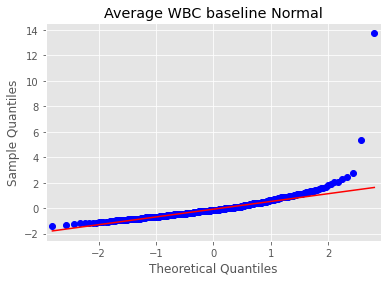

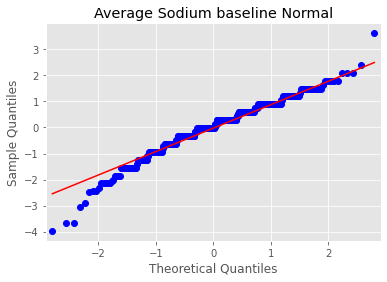

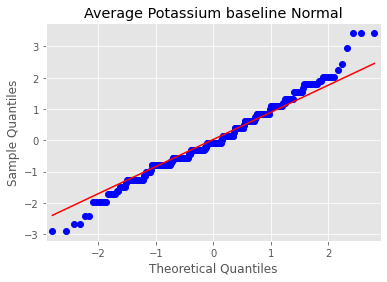

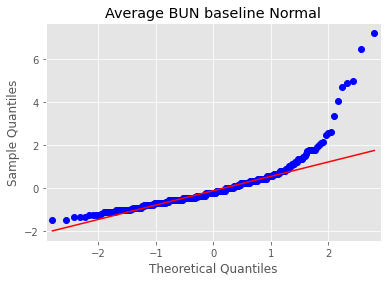

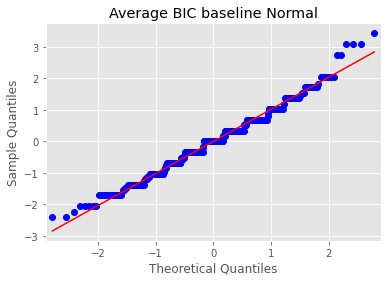

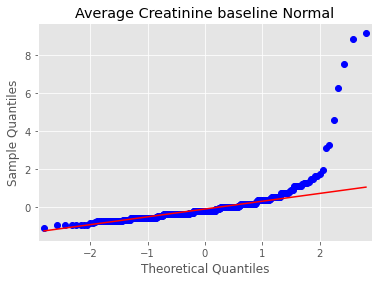

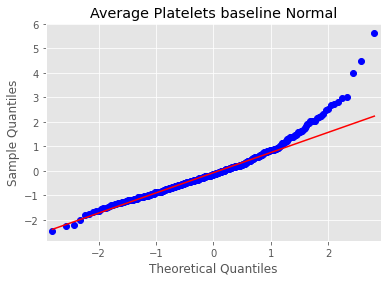

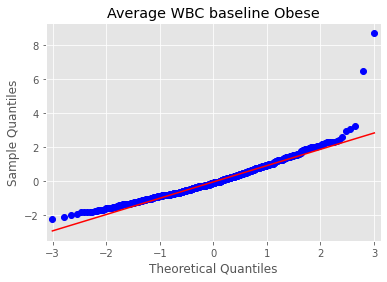

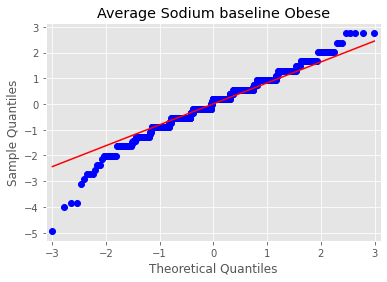

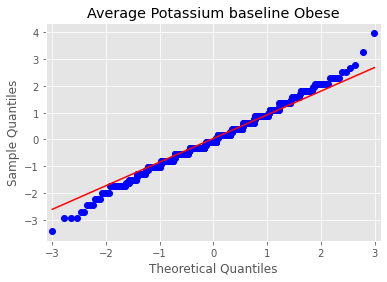

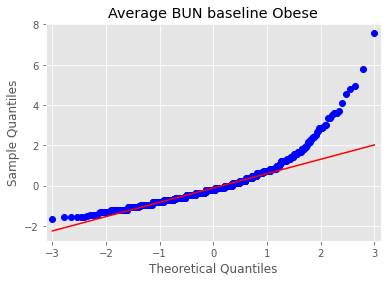

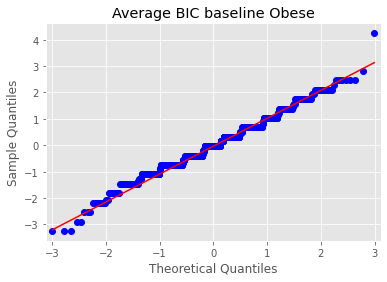

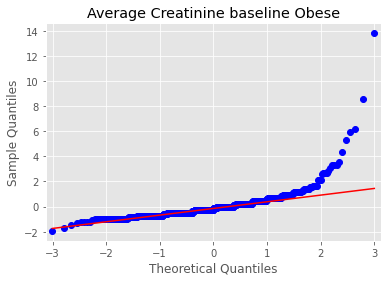

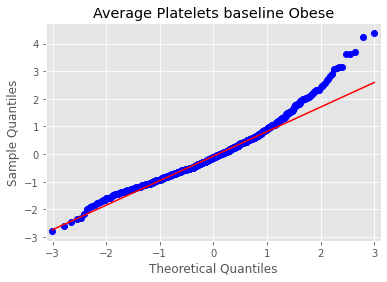

In [6]:
##apply qqplot on data without NA present. 


##Normal population 
sm.qqplot(baseline_lab_results_norm.iloc[:,3][np.isfinite(baseline_lab_results_norm.iloc[:,3])], line='q',fit = True)
plt.title('Average WBC baseline Normal')

sm.qqplot(baseline_lab_results_norm.iloc[:,4][np.isfinite(baseline_lab_results_norm.iloc[:,4])], line='q',fit = True)
plt.title('Average Sodium baseline Normal')

sm.qqplot(baseline_lab_results_norm.iloc[:,5][np.isfinite(baseline_lab_results_norm.iloc[:,5])],line='q',fit = True)
plt.title('Average Potassium baseline Normal')

sm.qqplot(baseline_lab_results_norm.iloc[:,6][np.isfinite(baseline_lab_results_norm.iloc[:,6])], line='q',fit = True)
plt.title('Average BUN baseline Normal')

sm.qqplot(baseline_lab_results_norm.iloc[:,7][np.isfinite(baseline_lab_results_norm.iloc[:,7])], line='q',fit = True)
plt.title('Average BIC baseline Normal')

sm.qqplot(baseline_lab_results_norm.iloc[:,8][np.isfinite(baseline_lab_results_norm.iloc[:,8])], line='q',fit = True)
plt.title('Average Creatinine baseline Normal')

sm.qqplot(baseline_lab_results_norm.iloc[:,9][np.isfinite(baseline_lab_results_norm.iloc[:,9])], line='q',fit = True)
plt.title('Average Platelets baseline Normal')

#Obese population 
sm.qqplot(baseline_lab_results_obese.iloc[:,3][np.isfinite(baseline_lab_results_obese.iloc[:,3])], line='q',fit = True)
plt.title('Average WBC baseline Obese')

sm.qqplot(baseline_lab_results_obese.iloc[:,4][np.isfinite(baseline_lab_results_obese.iloc[:,4])], line='q',fit = True)
plt.title('Average Sodium baseline Obese')

sm.qqplot(baseline_lab_results_obese.iloc[:,5][np.isfinite(baseline_lab_results_obese.iloc[:,5])],line='q',fit = True)
plt.title('Average Potassium baseline Obese')

sm.qqplot(baseline_lab_results_obese.iloc[:,6][np.isfinite(baseline_lab_results_obese.iloc[:,6])], line='q',fit = True)
plt.title('Average BUN baseline Obese')

sm.qqplot(baseline_lab_results_obese.iloc[:,7][np.isfinite(baseline_lab_results_obese.iloc[:,7])], line='q',fit = True)
plt.title('Average BIC baseline Obese')

sm.qqplot(baseline_lab_results_obese.iloc[:,8][np.isfinite(baseline_lab_results_obese.iloc[:,8])], line='q',fit = True)
plt.title('Average Creatinine baseline Obese')

sm.qqplot(baseline_lab_results_obese.iloc[:,9][np.isfinite(baseline_lab_results_obese.iloc[:,9])], line='q',fit = True)
plt.title('Average Platelets baseline Obese')


plt.show()
 


Based on the  Q_Q plots we can see that most variables deviate from normality.



Merge baseline results for ICU and baseline tables for normal and obese populations and generate difference column. 

In [7]:
##normal population
dev_merge_norm = ICU_lab_results_norm.merge(baseline_lab_results_norm, how='left', on='stay_id')
#calculate differences
dev_merge_norm['diff_wbc'] = dev_merge_norm['icu_wbc'] - dev_merge_norm['avgwbc_baseline']
dev_merge_norm['diff_sodium'] = dev_merge_norm['icu_NA'] - dev_merge_norm['avgsodium_baseline']
dev_merge_norm['diff_potasium'] = dev_merge_norm['icu_k'] - dev_merge_norm['avgpotassium_baseline']
dev_merge_norm['diff_BUN'] = dev_merge_norm['icu_BUN'] - dev_merge_norm['avgbun_baseline']
dev_merge_norm['diff_BIC'] = dev_merge_norm['icu_BIC'] - dev_merge_norm['avgbic_baseline']
dev_merge_norm['diff_platelets'] = dev_merge_norm['icu_platelets'] - dev_merge_norm['avgplatelets_baseline']


norm_dev=dev_merge_norm.iloc[:,-6:]
norm_dev.head()


##obese population
dev_merge_obese = ICU_lab_results_obese.merge(baseline_lab_results_obese, how='left', on='stay_id')
#calculate differences
dev_merge_obese['diff_wbc'] = dev_merge_obese['icu_wbc'] - dev_merge_obese['avgwbc_baseline']
dev_merge_obese['diff_sodium'] = dev_merge_obese['icu_NA'] - dev_merge_obese['avgsodium_baseline']
dev_merge_obese['diff_potasium'] = dev_merge_obese['icu_k'] - dev_merge_obese['avgpotassium_baseline']
dev_merge_obese['diff_BUN'] = dev_merge_obese['icu_BUN'] - dev_merge_obese['avgbun_baseline']
dev_merge_obese['diff_BIC'] = dev_merge_obese['icu_BIC'] - dev_merge_obese['avgbic_baseline']
dev_merge_obese['diff_platelets'] = dev_merge_obese['icu_platelets'] - dev_merge_obese['avgplatelets_baseline']


obese_dev=dev_merge_obese.iloc[:,-6:]
obese_dev.head()

diff_wbc  diff_sodium  diff_potasium  diff_BUN  diff_BIC  diff_platelets
0     12.10         -3.0          -0.40      -2.0      -5.0          -157.0
1     12.60          0.0           0.20      -2.0      -4.5           -77.0
2      6.65          0.0           0.20      -4.0       0.5           -29.5
3      7.15         -2.0           0.60      -3.0      -2.0           -34.0
4     12.00          3.0          -0.25      -5.5      -2.0            11.5

Generate Q-Q plots for deviation between ICU and baseline results 

Text(0.5, 1.0, 'ICU – baseline Creatinine obese')

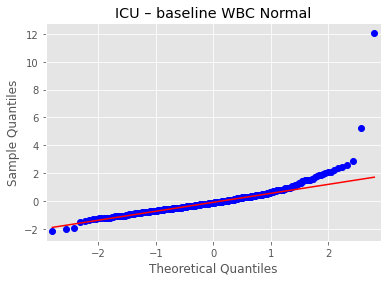

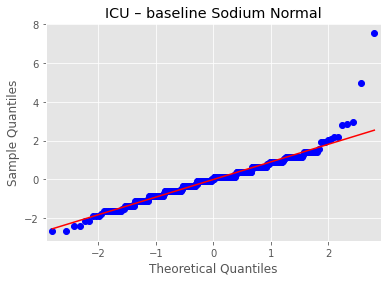

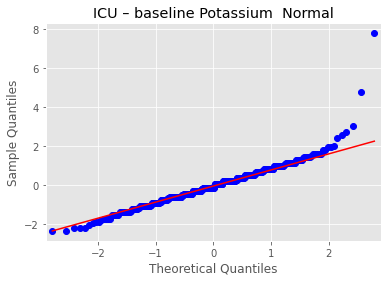

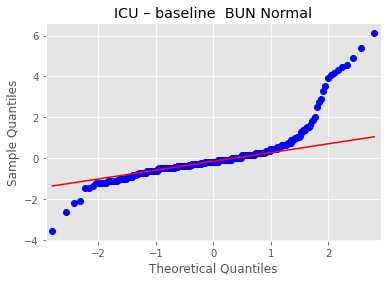

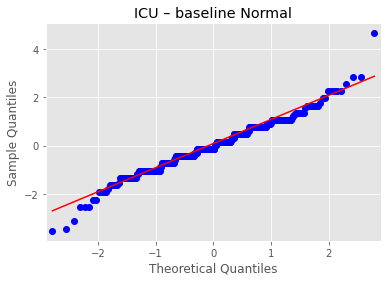

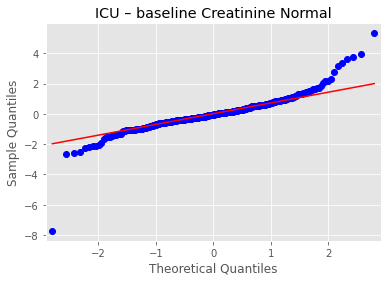

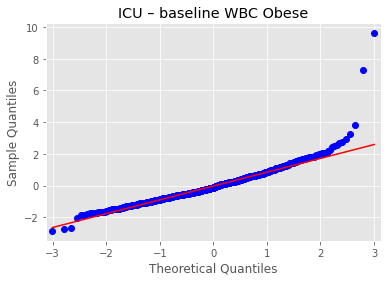

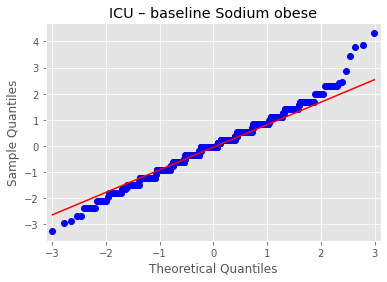

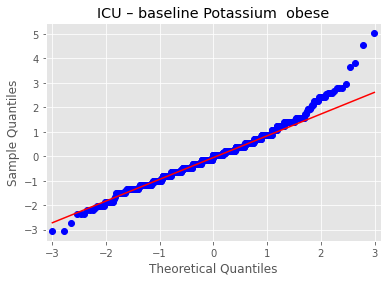

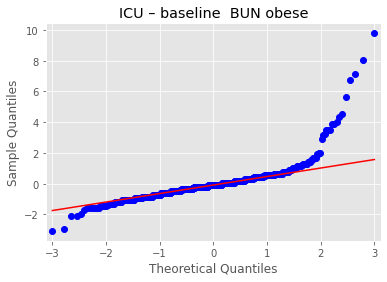

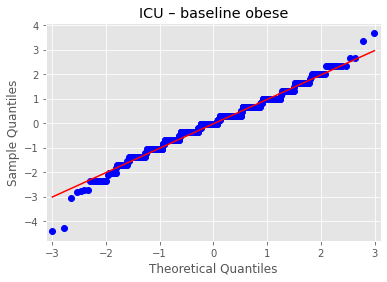

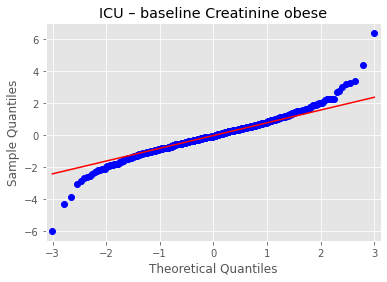

In [8]:

##Normal population  deviation
sm.qqplot(norm_dev.iloc[:,0][np.isfinite(norm_dev.iloc[:,0])], line='q',fit = True)
plt.title('ICU – baseline WBC Normal')

sm.qqplot(norm_dev.iloc[:,1][np.isfinite(norm_dev.iloc[:,1])], line='q',fit = True)
plt.title('ICU – baseline Sodium Normal')

sm.qqplot(norm_dev.iloc[:,2][np.isfinite(norm_dev.iloc[:,2])],line='q',fit = True)
plt.title('ICU – baseline Potassium  Normal')

sm.qqplot(norm_dev.iloc[:,3][np.isfinite(norm_dev.iloc[:,3])], line='q',fit = True)
plt.title('ICU – baseline  BUN Normal')

sm.qqplot(norm_dev.iloc[:,4][np.isfinite(norm_dev.iloc[:,4])], line='q',fit = True)
plt.title('ICU – baseline Normal')

sm.qqplot(norm_dev.iloc[:,5][np.isfinite(norm_dev.iloc[:,5])], line='q',fit = True)
plt.title('ICU – baseline Creatinine Normal')





##Obese population  deviation
sm.qqplot(obese_dev.iloc[:,0][np.isfinite(obese_dev.iloc[:,0])], line='q',fit = True)
plt.title('ICU – baseline WBC Obese')

sm.qqplot(obese_dev.iloc[:,1][np.isfinite(obese_dev.iloc[:,1])], line='q',fit = True)
plt.title('ICU – baseline Sodium obese')

sm.qqplot(obese_dev.iloc[:,2][np.isfinite(obese_dev.iloc[:,2])],line='q',fit = True)
plt.title('ICU – baseline Potassium  obese')

sm.qqplot(obese_dev.iloc[:,3][np.isfinite(obese_dev.iloc[:,3])], line='q',fit = True)
plt.title('ICU – baseline  BUN obese')

sm.qqplot(obese_dev.iloc[:,4][np.isfinite(obese_dev.iloc[:,4])], line='q',fit = True)
plt.title('ICU – baseline obese')

sm.qqplot(obese_dev.iloc[:,5][np.isfinite(obese_dev.iloc[:,5])], line='q',fit = True)
plt.title('ICU – baseline Creatinine obese')




Based on the results we can see that most variables deviate from normality. With BUN and creatinine appearing most skewed.

TABLE 2. Laboratory Results at Baseline and Change in Results Between ICU and Baseline generation 

In [9]:
#Baseline laboratory study
# extract columns take median, and calculate percentiles concatenate to get IQR
#for normal population
s1= baseline_lab_results_norm.iloc[:,3:9].median()
s2_1=baseline_lab_results_norm.iloc[:,3:9].quantile(0.25)
s2_2=baseline_lab_results_norm.iloc[:,3:9].quantile(0.75)
s2_3= pd.concat([s1,s2_1, s2_2], axis=1).reset_index()
s2_3['IQR']=s2_3[0.25].astype(str) + '-' + s2_3[0.75].astype(str)
s2_3 = s2_3.iloc[:,[1,4]]

#for obese population

s3= baseline_lab_results_obese.iloc[:,3:9].median()
s4_1=baseline_lab_results_obese.iloc[:,3:9].quantile(0.25)
s4_2=baseline_lab_results_obese.iloc[:,3:9].quantile(0.75)
s4_3= pd.concat([s3,s4_1, s4_2], axis=1).reset_index()
s4_3['IQR']=s4_3[0.25].astype(str) + '-' + s4_3[0.75].astype(str)
s4_3=s4_3.iloc[:,[1,4]]

# Join both populations, obese and 
final_baseline=pd.concat([s2_3, s4_3], axis=1).reset_index()
final_baseline=final_baseline.iloc[:,-4:]


#rename index

final_baseline.rename(index={0:'WBC',1:'sodium',2:'potassium',3:'BUN',4:'BIC',5:'creatinine'},inplace=True)


#rename columns: 

final_baseline.columns = ['base_med_norm', 'base_IQR_norm', 'base_med_obese', 'base_IQR_obese']
final_baseline


base_med_norm base_IQR_norm  base_med_obese base_IQR_obese
WBC                   6.6     5.5-8.275        7.200000        6.0-8.7
sodium              139.0   137.0-141.0      140.000000    138.0-141.0
potassium             4.2       4.0-4.5        4.200000        4.0-4.5
BUN                  17.0     14.0-22.0       18.000000      15.0-23.0
BIC                  27.0     25.0-29.0       26.000000      24.0-28.0
creatinine            0.9       0.8-1.1        0.929167        0.8-1.1

Baseline laboratory results

In [10]:

#ICU- Baseline laboratory results

                
s1=norm_dev.mean()
s2=np.std(norm_dev)
s3=obese_dev.mean()
s4=np.std(obese_dev)
norm_dev.mean()

ICU_base_dev= pd.concat([s1, s2,s2,s3], axis=1).reset_index()
ICU_base_dev.columns=['Variable','diff normal mean', 'diff normal std', 'diff obese mean', 'diff obese std']

ICU_base_dev

Variable  diff normal mean  diff normal std  diff obese mean  \
0        diff_wbc          7.811892         6.299468         6.299468   
1     diff_sodium          0.437544         3.918165         3.918165   
2   diff_potasium          0.274636         0.631614         0.631614   
3        diff_BUN         -0.311168         9.480285         9.480285   
4        diff_BIC         -2.524661         3.337815         3.337815   
5  diff_platelets        -49.920220        66.467870        66.467870   

   diff obese std  
0        8.819351  
1        0.168189  
2        0.382120  
3       -0.289706  
4       -1.903783  
5      -35.504343

Mege relevant tables to get all variables in study

In [11]:
#concatenate tables: 
lab_tot=pd.concat([dev_merge_norm,dev_merge_obese])
baseline_dem_tot=pd.concat([baseline_dem_norm,baseline_dem_obese])
severity_score_tot= pd.concat([severity_score_norm,severity_score_obese])

##left join to demographics table

tot_fin=lab_tot.merge(baseline_dem_tot, on='stay_id', how='left')

#add log BUN for baseline values 

tot_fin.head()



stay_id  bmi_group_x  icu_wbc  icu_platelets  icu_NA  icu_k  icu_BUN  \
0  30008105            0     13.3          162.0   136.0    4.6      9.0   
1  30016009            0      9.3          143.0   143.0    4.3     26.0   
2  30047249            0      6.0          150.0   142.0    4.5     17.0   
3  30047249            0      6.0          150.0   142.0    4.5     17.0   
4  30117047            0     13.6          143.0   136.0    4.9     17.0   

   icu_Cr  icu_BIC  subject_id_x  ...  ethnicity         admittime_1  \
0     0.7     23.0    14036785.0  ...      WHITE 2146-10-29 00:00:00   
1     1.0     24.0    11317133.0  ...    UNKNOWN 2129-09-21 07:15:00   
2     0.6     33.0    16782996.0  ...      WHITE 2158-04-01 07:15:00   
3     0.6     33.0    16782996.0  ...      WHITE 2158-04-01 07:15:00   
4     1.0     22.0    15956706.0  ...      WHITE 2121-05-25 13:17:00   

            dischtime  hospital_expire_flag  marital_status_fin  \
0 2146-11-02 17:56:00                     0             Married   
1 2129-09-27 13:40:00                     0       other/unknown   
2 2158-04-09 15:00:00                     0             Married   
3 2158-04-09 15:00:00                     0             Married   
4 2121-06-01 17:30:00                     0       other/unknown   

       insurance_fin  admission_type_fin  source_of_admission_fin  \
0  Medicare/Medicaid               Other       Physician referral   
1      Private/Other               Other       Physician referral   
2      Private/Other               Other       Physician referral   
3      Private/Other               Other       Physician referral   
4  Medicare/Medicaid           Emergency       Physician referral   

                             icu_adm_type_fin  charlson_comorbidity_index  
0               Cardiac surgery recovery unit                           4  
1               Cardiac surgery recovery unit                           8  
2  Surgical ICU/trauma ICU/coronary care unit                           1  
3  Surgical ICU/trauma ICU/coronary care unit                           1  
4               Cardiac surgery recovery unit                           7  

[5 rows x 50 columns]

Generate a profile report for final dataframe of variables in study

In [12]:
profile = ProfileReport(tot_fin, title="Pandas Profiling Report", minimal=True)
profile

Summarize dataset:   0%|          | 0/58 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]